## seasonal patterns of NLCT events

In [1]:
import glob
import xarray as xr
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

In [2]:
nlct_path = "/mnt/data2/jturner/nlct_data/oaxaca/"

Creating seasonal average for month: 

In [3]:
month = '12' #mm
month_name = 'Dec'

In [4]:
files = sorted(glob.glob(nlct_path+'202?'+month+'*/*00H_00M'))

In [5]:
for file in files: 
    print(file.split('/')[-2])

20221201
20221202
20221203
20221204
20221205
20221206
20221207
20221208
20221209
20221210
20221211
20221212
20221213
20221214
20221215
20221216
20221217
20221218
20221219
20221220
20221221
20221222
20221223
20221224
20221225
20221226
20221227
20221228
20221229
20221230
20221231


Each NLCT file is a saved xarray DataArray, they need the dictionary to be appended into a Dataset:

In [6]:
datasets = []

for file in files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        my_dict = {'BTD': data} 
        ds = xr.Dataset(my_dict)
        
        #--- Set negative values to zero
        ds['BTD'] = xr.where(ds['BTD'] < 0, 0, ds['BTD'])

        #--- Set positive values to 1
        #ds['BTD'] = xr.where(ds['BTD'] > 0, 1, ds['BTD'])
        
        datasets.append(ds)

nlst_ds = xr.concat(datasets, dim='time')

In [8]:
max_x = np.max(nlst_ds.x.values) -0.025
min_x = np.min(nlst_ds.x.values) +0.025
max_y = np.max(nlst_ds.y.values) -0.005
min_y = np.min(nlst_ds.y.values) +0.005

x_range = slice(min_x, max_x)
y_range = slice(max_y, min_y)

nlst_ds_sm = nlst_ds.sel(x=x_range, y=y_range)

In [9]:
btd_mean = nlst_ds_sm['BTD'].sum(dim='time')

In [10]:
overall_mean = btd_mean.mean(dim='y')
overall_mean = overall_mean.mean(dim='x')

In [11]:
high_lim = overall_mean.values
low_lim = overall_mean.values

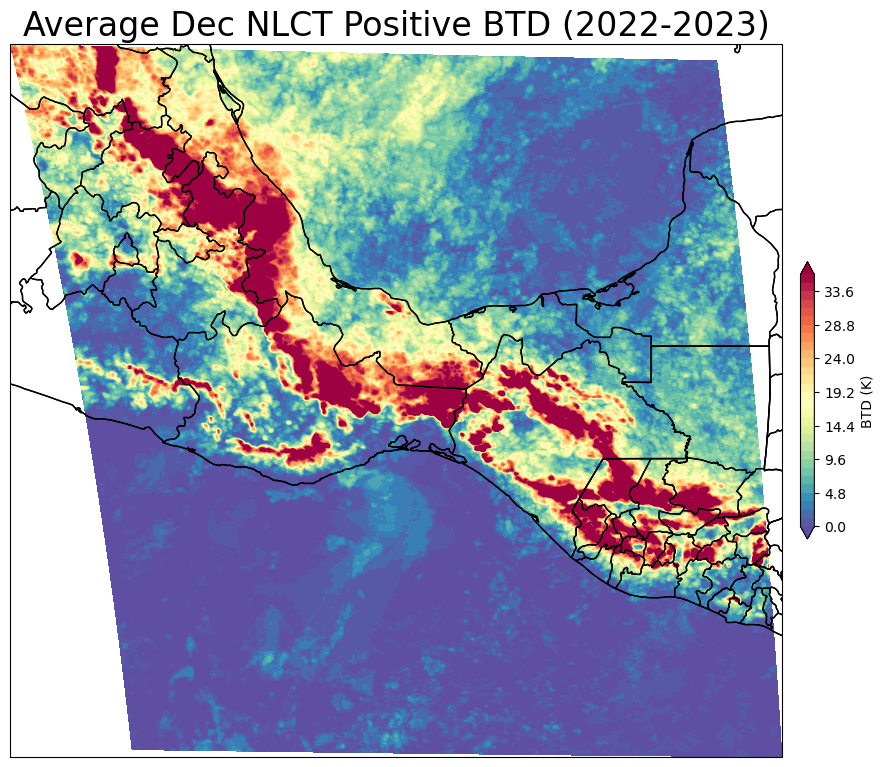

In [12]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 36, 31)

c=ax.contourf(btd_mean.lon, btd_mean.lat, btd_mean, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Average '+month_name+' NLCT Positive BTD (2022-2023)', fontsize=24)
clb.set_label('BTD (K)')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#plt.savefig('NLCT_Seasonal/'+month_name+'_nclt.png', bbox_inches='tight')

In [13]:
def Calc_BTD_mean(month_id):
    
    #--- Create month number
    month_num = str(month_id+1).zfill(2)
    
    print(month_num)
    files = sorted(glob.glob(nlct_path+'202?'+month_num+'*/*00H_00M'))
    datasets = []

    for file in files:
        with open(file, 'rb') as f:
            data = pickle.load(f)
            my_dict = {'BTD': data} 
            ds = xr.Dataset(my_dict)

            #--- Set negative values to zero
            ds['BTD'] = xr.where(ds['BTD'] < 0, 0, ds['BTD'])

            datasets.append(ds)

    nlst_ds = xr.concat(datasets, dim='time')
    nlst_ds_sm = nlst_ds.sel(x=x_range, y=y_range)
    btd_mean = nlst_ds_sm['BTD'].sum(dim='time')
    
    return btd_mean

01
02
03
04
05
06
07
08
09
10
11
12


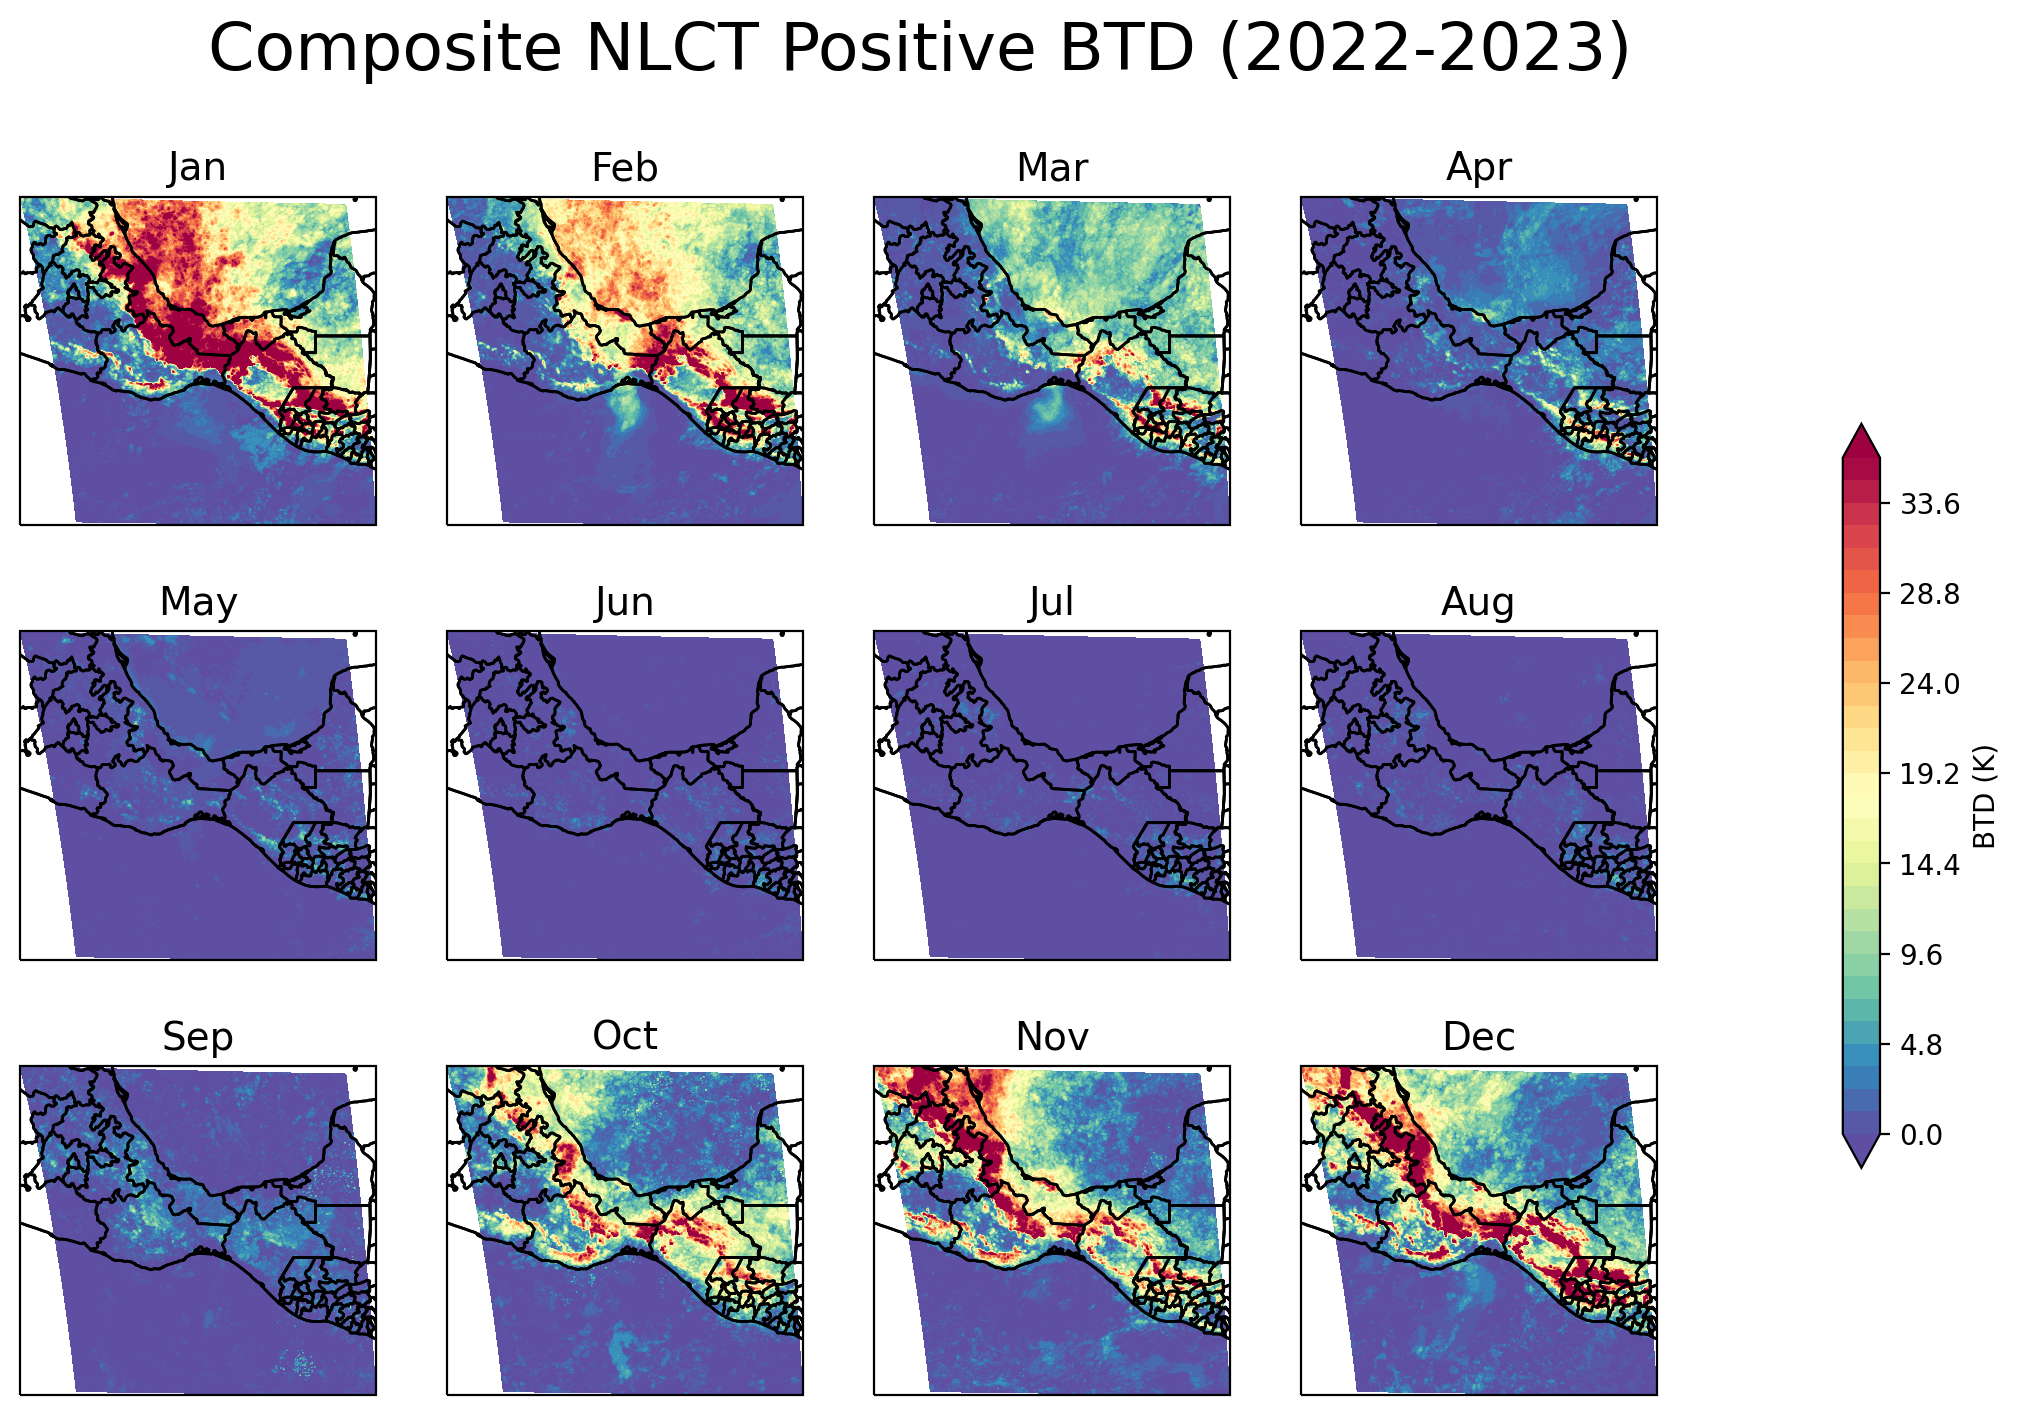

In [15]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#--- Calculate the number of rows and columns for the subplots
num_months = len(months)
num_rows = int(num_months**0.5)
num_cols = (num_months + num_rows - 1) // num_rows

#--- Create a figure and an array of subplots
projection=ccrs.PlateCarree()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8), subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 36, 31)

#--- Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

for i, month in enumerate(months):
    btd_mean = Calc_BTD_mean(i)
    c=axes[i].contourf(btd_mean.lon, btd_mean.lat, btd_mean, cmap=cmap, extend='both', levels=levels)
    axes[i].set_title(month, fontsize=14)
    axes[i].add_feature(cfeature.STATES)
    axes[i].add_feature(cfeature.BORDERS)
    axes[i].add_feature(cfeature.COASTLINE)

    
cbar = plt.colorbar(c, ax=axes, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('BTD (K)')  

    
fig.suptitle('Composite NLCT Positive BTD (2022-2023)', fontsize=24)
fig.set_dpi(200)
plt.show()